In [2]:
import os
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # avoid OpenMP runtime clash

import sys
import types
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [22]:
# ---------------------------------------------------------------------------
# 1. Dataset: use connectivity_matrix directly (no PyG)
# ---------------------------------------------------------------------------

class LatticePlainDataset(Dataset):
    """
    Each item:
        A   : [N, N] adjacency / connectivity matrix (float32)
        X   : [N, F] node features (degree, rho)
        y   : [num_targets] target engineering constants
    """

    def __init__(self, df: pd.DataFrame, target_cols=None):
        if target_cols is None:
            target_cols = ["E1", "E2", "E3", "G12", "G23", "G13"]

        self.target_cols = target_cols

        # assume all connectivity_matrices have same shape (N x N)
        first_A = np.asarray(df.iloc[0]["connectivity_matrix"], dtype=float)
        self.N = first_A.shape[0]

        self.As = []
        self.Xs = []
        self.ys = []
        self.rhos = []

        for _, row in df.iterrows():
            A = np.asarray(row["connectivity_matrix"], dtype=float)
            if A.shape != (self.N, self.N):
                raise ValueError(f"Inconsistent connectivity matrix shape: {A.shape}, expected {(self.N, self.N)}")

            # adjacency with self-loops
            A_with_self = A.copy()
            np.fill_diagonal(A_with_self, 1.0)

            # node features: [degree, rho]
            deg = A.sum(axis=1) + A.sum(axis=0)
            rho = torch.tensor([float(row["ρ"])], dtype=torch.float32)
            X = torch.tensor(deg, dtype=torch.float32).unsqueeze(1)  #left rho out so it can run as an independent feature

            y = np.array([row[col] for col in target_cols], dtype=float)

            self.As.append(torch.tensor(A_with_self, dtype=torch.float32))
            self.Xs.append(torch.tensor(X, dtype=torch.float32))
            self.rhos.append(torch.tensor([rho], dtype=torch.float32))
            self.ys.append(torch.tensor(y, dtype=torch.float32))

    def __len__(self):
        return len(self.As)

    def __getitem__(self, idx):
        return self.As[idx], self.Xs[idx],  self.rhos[idx], self.ys[idx]


# simple collate: stack along batch dimension
def lattice_collate(batch):
    As, Xs, rhos, ys = zip(*batch)
    A = torch.stack(As, dim=0)  # [B, N, N]
    X = torch.stack(Xs, dim=0)  # [B, N, F]
    rho = torch.stack(rhos, dim=0)
    y = torch.stack(ys, dim=0)  # [B, num_targets]
    return A, X, rho, y


In [4]:
# ---------------------------------------------------------------------------
# 2. Graph attention layer implemented in plain PyTorch
# ---------------------------------------------------------------------------

class MultiHeadGraphAttention(nn.Module):
    """
    Multi-head self-attention over nodes, masked by adjacency matrix.

    Input:
        X: [B, N, F_in]
        A: [B, N, N] (0/1; 1 means "can attend")
    Output:
        X_out: [B, N, F_out]
    """

    def __init__(self, in_dim, out_dim, num_heads=4, dropout=0.1):
        super().__init__()
        assert out_dim % num_heads == 0, "out_dim must be divisible by num_heads"

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_heads = num_heads
        self.d_k = out_dim // num_heads

        self.W_q = nn.Linear(in_dim, out_dim)
        self.W_k = nn.Linear(in_dim, out_dim)
        self.W_v = nn.Linear(in_dim, out_dim)

        self.out_proj = nn.Linear(out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, A):
        # X: [B, N, F_in], A: [B, N, N]
        B, N, _ = X.shape

        Q = self.W_q(X)  # [B, N, out_dim]
        K = self.W_k(X)
        V = self.W_v(X)

        # reshape for multi-head: [B, h, N, d_k]
        B, N, _ = Q.shape
        h = self.num_heads
        d_k = self.d_k

        Q = Q.view(B, N, h, d_k).transpose(1, 2)  # [B, h, N, d_k]
        K = K.view(B, N, h, d_k).transpose(1, 2)  # [B, h, N, d_k]
        V = V.view(B, N, h, d_k).transpose(1, 2)  # [B, h, N, d_k]

        # attention scores: [B, h, N, N]
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

        # mask using adjacency: where A == 0, set score to large negative
        # expand A to [B, 1, N, N]
        A_expanded = A.unsqueeze(1)  # [B, 1, N, N]
        mask = (A_expanded <= 0)  # True where we should mask
        scores = scores.masked_fill(mask, -1e9)

        attn = torch.softmax(scores, dim=-1)  # [B, h, N, N]
        attn = self.dropout(attn)

        # weighted sum of V: [B, h, N, d_k]
        out = torch.matmul(attn, V)

        # merge heads: [B, N, h * d_k]
        out = out.transpose(1, 2).contiguous().view(B, N, h * d_k)

        # final linear
        out = self.out_proj(out)  # [B, N, out_dim]
        return out


In [5]:
# ---------------------------------------------------------------------------
# 3. Full model: stack attention layers + graph-level pooling
# ---------------------------------------------------------------------------

class AttentionGNN(nn.Module):
    def __init__(
        self,
        node_feat_dim,
        hidden_dim=64,
        num_heads=4,
        num_layers=3,
        out_dim=6,
        dropout=0.1,
    ):
        super().__init__()

        layers = []
        in_dim = node_feat_dim
        for i in range(num_layers):
            layers.append(
                MultiHeadGraphAttention(
                    in_dim=in_dim,
                    out_dim=hidden_dim,
                    num_heads=num_heads,
                    dropout=dropout,
                )
            )
            in_dim = hidden_dim

        self.layers = nn.ModuleList(layers)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # graph-level pooling: mean over nodes
        self.readout_mlp = nn.Sequential(
            nn.Linear(hidden_dim+1, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, A, X, rho):
        """
        A: [B, N, N]
        X: [B, N, F]
        """
        h = X
        for layer in self.layers:
            h_new = layer(h, A)  # [B, N, hidden]
            h = self.activation(h_new)
            h = self.dropout(h)

        # simple mean pooling over nodes
        graph_emb = h.mean(dim=1)  # [B, hidden_dim]
        graph_emb = torch.cat([graph_emb, rho], dim=1)

        out = self.readout_mlp(graph_emb)  # [B, out_dim]
        return out


In [6]:
# ---------------------------------------------------------------------------
# 4. Train / eval helpers
# ---------------------------------------------------------------------------

def split_dataset(dataset, train_frac=0.7, val_frac=0.15, seed=0):
    n = len(dataset)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)

    train_end = int(train_frac * n)
    val_end = int((train_frac + val_frac) * n)

    train_idx = idx[:train_end]
    val_idx = idx[train_end:val_end]
    test_idx = idx[val_end:]

    def _subset(indices):
        return torch.utils.data.Subset(dataset, indices)

    return _subset(train_idx), _subset(val_idx), _subset(test_idx)


In [7]:
def run_epoch(model, loader, optimizer, loss_fn, device, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_batches = 0

    with torch.set_grad_enabled(train):
        for A, X, rho, y in loader:
            A = A.to(device)
            X = X.to(device)
            y = y.to(device)

            pred = model(A, X, rho)
            loss = loss_fn(pred, y)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            total_batches += 1

    return total_loss / max(total_batches, 1)

In [8]:
import numpy as np
import numpy.core as _core
import numpy.core.numeric as _numeric

import sys

# Alias old private NumPy modules expected by the pickle
sys.modules.setdefault("numpy._core", _core)
sys.modules.setdefault("numpy._core.numeric", _numeric)


<module 'numpy.core.numeric' from '/opt/anaconda3/envs/chemclean/lib/python3.10/site-packages/numpy/core/numeric.py'>

In [9]:
def evaluate_split(loader, split_name, model, device):
    model.eval()
    ys, preds = [], []

    with torch.no_grad():
        for A, X, rho, y in loader:
            A = A.to(device)
            X = X.to(device)
            rho = rho.to(device) 
            y = y.to(device)          # [B, 6]

            pred = model(A, X, rho)        # [B, 6]

            # flatten into 1D vectors per batch
            t = y.cpu().numpy().ravel()
            p = pred.cpu().numpy().ravel()

            ys.append(t)
            preds.append(p)

    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(preds, axis=0)

    return pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "split": split_name,
    })


In [10]:
def to_float(x):
    if isinstance(x, (int, float, np.floating)):
        return float(x)

    # numpy array → use mean
    if isinstance(x, np.ndarray):
        return float(np.mean(x))

    # list/tuple → use mean
    if isinstance(x, (list, tuple)):
        return float(np.mean(x))

    # pandas Series → use mean
    if isinstance(x, pd.Series):
        return float(x.astype(float).mean())

    # last resort: try float() directly
    try:
        return float(x)
    except:
        raise TypeError(f"Cannot convert {type(x)} → float: {x}")


In [11]:
data_path = "/Users/katrinareyes/Desktop/Fall_25/CHEM_277B/chem-277b-group-project/data/real_data.pkl"

print("About to read pickle...")
df = pd.read_pickle(data_path)
print("Loaded df with shape:", df.shape)
print(df.columns[:10])  # first 10 column names
print(df["ρ"].apply(type).value_counts())


About to read pickle...
Loaded df with shape: (2624, 21)
Index(['ρ', 'connectivity_matrix', 'compliance_matrix',
       'compliance_components', 'E1', 'E2', 'E3', 'G23', 'G13', 'G12'],
      dtype='object')
ρ
<class 'float'>    2624
Name: count, dtype: int64


In [12]:
print(type(df["connectivity_matrix"].iloc[0]))
print(np.array(df["connectivity_matrix"].iloc[0]).shape)
print(df["connectivity_matrix"].iloc[0])


<class 'numpy.ndarray'>
(11, 11)
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [13]:
print(df["ρ"].apply(type).value_counts())
print(df["ρ"].head())


ρ
<class 'float'>    2624
Name: count, dtype: int64
0    0.3
1    0.3
2    0.3
3    0.3
4    0.3
Name: ρ, dtype: float64


In [14]:
target_cols = ["E1", "E2", "E3", "G12", "G23", "G13"]

dataset = LatticePlainDataset(df, target_cols=target_cols)
print(f"Built {len(dataset)} lattice samples with N={dataset.N} nodes each.")

# A0, X0, y0 = dataset[0]
# print("A0 shape:", A0.shape)
# print("X0 shape:", X0.shape)
# print("y0 shape:", y0.shape)


Built 2624 lattice samples with N=11 nodes each.


/var/folders/_x/bc1j7h695vs3bszy2dl6ltp00000gn/T/ipykernel_48071/3241453735.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Xs.append(torch.tensor(X, dtype=torch.float32))


In [15]:
batch_size = 32
num_epochs = 100
lr = 1e-3
weight_decay = 1e-4
seed = 0

dataset = LatticePlainDataset(df, target_cols=target_cols)
print(f"Built {len(dataset)} lattice samples with N={dataset.N} nodes each.")

train_set, val_set, test_set = split_dataset(dataset, seed=seed)
print(
    f"Split sizes → train: {len(train_set)}, "
    f"val: {len(val_set)}, test: {len(test_set)}"
)


Built 2624 lattice samples with N=11 nodes each.
Split sizes → train: 1836, val: 394, test: 394


/var/folders/_x/bc1j7h695vs3bszy2dl6ltp00000gn/T/ipykernel_48071/3241453735.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Xs.append(torch.tensor(X, dtype=torch.float32))


In [16]:
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, collate_fn=lattice_collate
)
val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=False, collate_fn=lattice_collate
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=False, collate_fn=lattice_collate
)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
node_feat_dim = dataset.Xs[0].shape[1]  # 2 (degree, rho)

model = AttentionGNN(
    node_feat_dim=node_feat_dim,
    hidden_dim=64,
    num_heads=4,
    num_layers=3,
    out_dim=len(target_cols),
    dropout=0.1,
).to(device)

In [18]:
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=weight_decay
)
loss_fn = nn.MSELoss()

print("Starting training on device:", device)

for epoch in range(1, num_epochs + 1):
    train_loss = run_epoch(
        model, train_loader, optimizer, loss_fn, device, train=True
    )
    val_loss = run_epoch(
        model, val_loader, optimizer, loss_fn, device, train=False
    )

    if epoch == 1 or epoch % 10 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"train_loss = {train_loss:.6f} | val_loss = {val_loss:.6f}"
        )

# final test evaluation
test_loss = run_epoch(
    model, test_loader, optimizer, loss_fn, device, train=False
)
print(f"Final test loss: {test_loss:.6f}")


Starting training on device: cpu
Epoch 001 | train_loss = 0.001013 | val_loss = 0.000340
Epoch 010 | train_loss = 0.000201 | val_loss = 0.000207
Epoch 020 | train_loss = 0.000189 | val_loss = 0.000218
Epoch 030 | train_loss = 0.000184 | val_loss = 0.000207
Epoch 040 | train_loss = 0.000185 | val_loss = 0.000207
Epoch 050 | train_loss = 0.000184 | val_loss = 0.000212
Epoch 060 | train_loss = 0.000183 | val_loss = 0.000207
Epoch 070 | train_loss = 0.000183 | val_loss = 0.000209
Epoch 080 | train_loss = 0.000183 | val_loss = 0.000207
Epoch 090 | train_loss = 0.000185 | val_loss = 0.000207
Epoch 100 | train_loss = 0.000184 | val_loss = 0.000206
Final test loss: 0.000176


y_true range: 6.0988e-09 -> 0.15640174
y_pred range: 0.00838915 -> 0.060962796


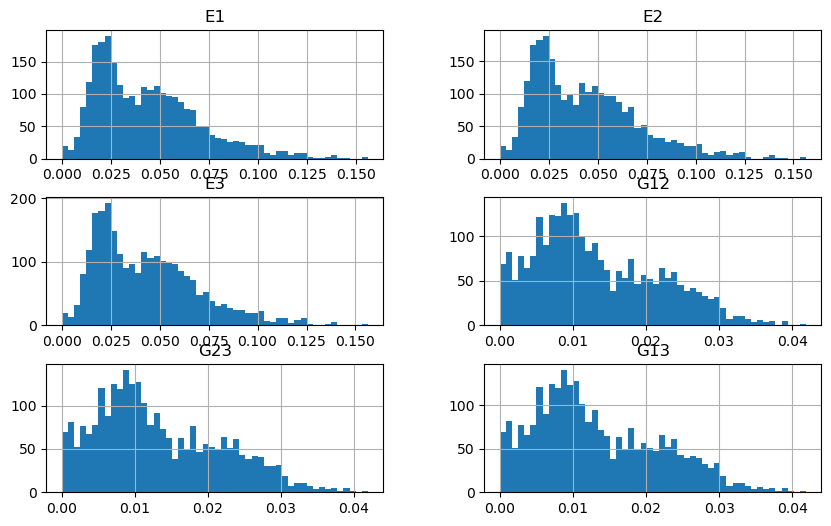

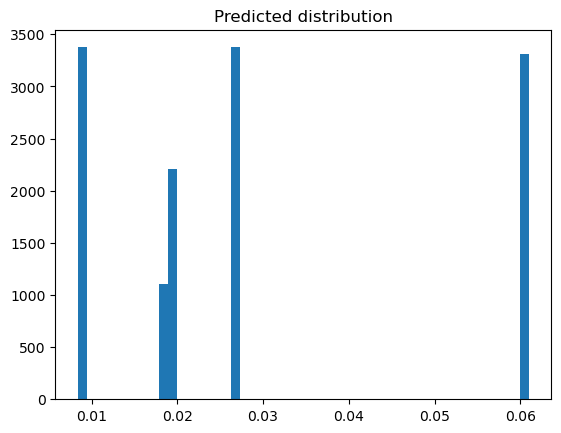

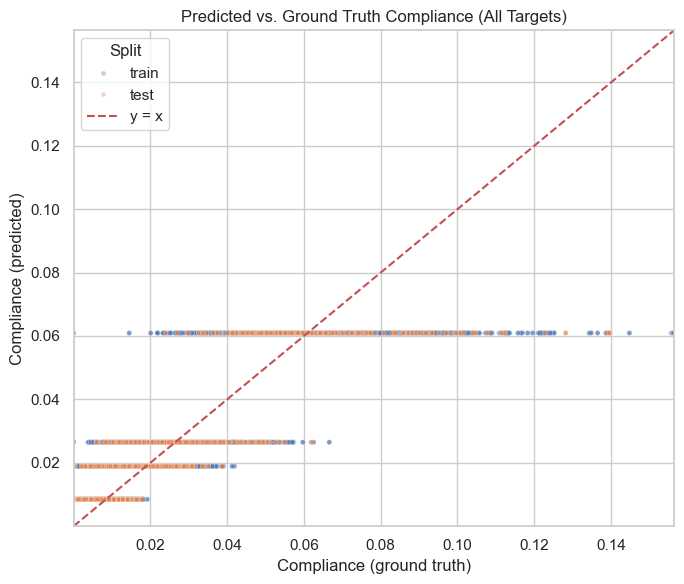

In [19]:

train_df = evaluate_split(train_loader, "train", model, device)
test_df  = evaluate_split(test_loader,  "test",  model, device)
comb_df  = pd.concat([train_df, test_df], ignore_index=True)

print("y_true range:", comb_df["y_true"].min(), "->", comb_df["y_true"].max())
print("y_pred range:", comb_df["y_pred"].min(), "->", comb_df["y_pred"].max())

df[target_cols].hist(bins=50, figsize=(10,6))
plt.show()



all_preds = comb_df["y_pred"]
plt.hist(all_preds, bins=50)
plt.title("Predicted distribution")
plt.show()





sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7, 6))

sns.scatterplot(
    data=comb_df,
    x="y_true",
    y="y_pred",
    hue="split",
    alpha=0.35,
    s=12,
    ax=ax
)

xy_min = float(min(comb_df["y_true"].min(), comb_df["y_pred"].min()))
xy_max = float(max(comb_df["y_true"].max(), comb_df["y_pred"].max()))

ax.axline((0, 0), slope=1.0, color="r",
            linestyle="--", linewidth=1.5, label="y = x")

ax.set_xlim(xy_min, xy_max)
ax.set_ylim(xy_min, xy_max)
ax.set_xlabel("Compliance (ground truth)")
ax.set_ylabel("Compliance (predicted)")
ax.legend(title="Split")
ax.set_title("Predicted vs. Ground Truth Compliance (All Targets)")

plt.tight_layout()
plt.show()


In [20]:
print("ρ variation:")
print(df["ρ"].describe())

print("Target column variations:")
print(df[["E1","E2","E3","G12","G23","G13"]].describe())

print("Checking how many unique degree vectors exist:")
degree_signatures = []

for A in df["connectivity_matrix"]:
    A = np.array(A)
    deg = tuple((A.sum(0) + A.sum(1)).tolist())  # degree vector
    degree_signatures.append(deg)

print("Unique degree patterns:", len(set(degree_signatures)))
print("Fraction unique:", len(set(degree_signatures))/len(degree_signatures))


ρ variation:
count    2624.000000
mean        0.224886
std         0.075014
min         0.150000
25%         0.150000
50%         0.150000
75%         0.300000
max         0.300000
Name: ρ, dtype: float64
Target column variations:
                 E1            E2            E3           G12           G23  \
count  2.624000e+03  2.624000e+03  2.624000e+03  2.624000e+03  2.624000e+03   
mean   4.365609e-02  4.363517e-02  4.361189e-02  1.327812e-02  1.328227e-02   
std    2.630132e-02  2.628379e-02  2.626363e-02  8.512915e-03  8.514896e-03   
min    1.073708e-08  2.116569e-08  9.641646e-09  6.098800e-09  8.549100e-09   
25%    2.248594e-02  2.248362e-02  2.244388e-02  6.883450e-03  6.872125e-03   
50%    3.906805e-02  3.902576e-02  3.901335e-02  1.130550e-02  1.130400e-02   
75%    5.922094e-02  5.921026e-02  5.917851e-02  1.949225e-02  1.950600e-02   
max    1.563354e-01  1.564017e-01  1.563803e-01  4.189300e-02  4.191600e-02   

                G13  
count  2.624000e+03  
mean   1.3272

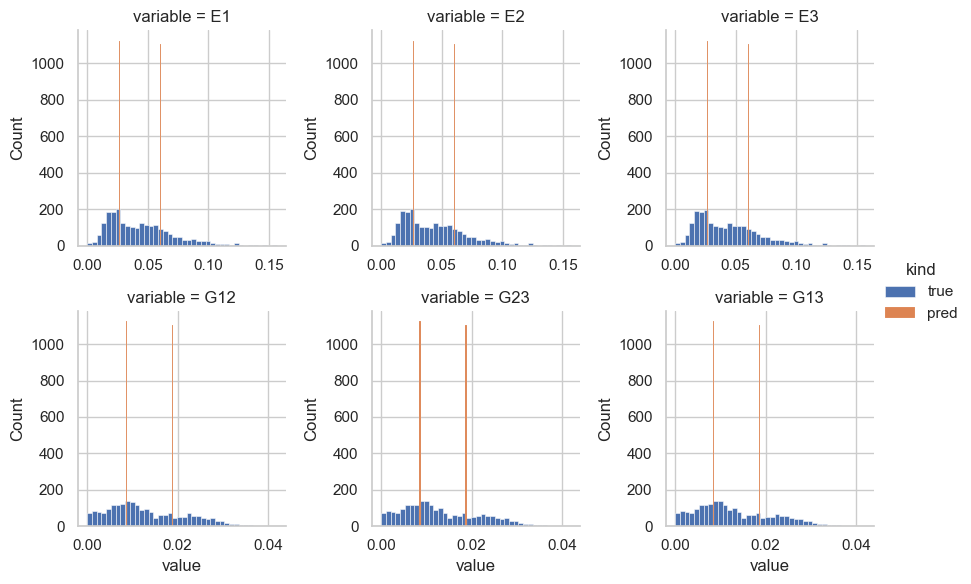

In [21]:
plot_df = []

for i, name in enumerate(target_cols):
    mask = np.arange(len(comb_df)) % 6 == i
    vals_true = comb_df["y_true"][mask].values
    vals_pred = comb_df["y_pred"][mask].values

    tmp = pd.DataFrame({
        "value": np.concatenate([vals_true, vals_pred]),
        "kind": ["true"] * len(vals_true) + ["pred"] * len(vals_pred),
        "variable": name
    })
    plot_df.append(tmp)

plot_df = pd.concat(plot_df, ignore_index=True)

g = sns.FacetGrid(plot_df, col="variable", hue="kind", col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, "value", bins=40, alpha=1)
g.add_legend()
plt.show()

